In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, cohen_kappa_score
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler

# Load data
Trained_Data = pd.read_csv("../input/nslkdd/KDDTrain+.txt", sep=",", header=None)
Tested_Data = pd.read_csv("../input/nslkdd/KDDTest+.txt", sep=",", header=None)

# Define column names
Columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
           'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
           'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
           'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
           'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
           'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
           'dst_host_srv_rerror_rate','attack','level']
Trained_Data.columns = Columns
Tested_Data.columns = Columns

# Function to change attack labels to their respective attack class
def change_label(df):
    df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
    df.attack.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail','snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)      
    df.attack.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
    df.attack.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

change_label(Trained_Data)
change_label(Tested_Data)

# Label encoding (0,1,2,3,4) multi-class labels (Dos,normal,Probe,R2L,U2R)
LE = LabelEncoder()
Trained_Data['attack_state'] = LE.fit_transform(Trained_Data["attack"])
Tested_Data['attack_state'] = LE.transform(Tested_Data["attack"])

# Ensure columns exist before calling pd.get_dummies
if all(col in Trained_Data.columns for col in ['protocol_type', 'service', 'flag']):
    Trained_Data = pd.get_dummies(Trained_Data, columns=['protocol_type','service','flag'], prefix="", prefix_sep="")
if all(col in Tested_Data.columns for col in ['protocol_type', 'service', 'flag']):
    Tested_Data = pd.get_dummies(Tested_Data, columns=['protocol_type','service','flag'], prefix="", prefix_sep="")

X_train = Trained_Data.drop(['attack', 'level', 'attack_state'], axis=1)
X_test = Tested_Data.drop(['attack', 'level', 'attack_state'], axis=1)

Y_train = Trained_Data['attack_state']
Y_test = Tested_Data['attack_state']

X_train_train, X_test_train, Y_train_train, Y_test_train = train_test_split(X_train, Y_train, test_size=0.25, random_state=42)
X_train_test, X_test_test, Y_train_test, Y_test_test = train_test_split(X_test, Y_test, test_size=0.25, random_state=42)

# Apply SMOTE to the training data to address class imbalance
smote = SMOTE(random_state=55)
X_train_train_smote, Y_train_train_smote = smote.fit_resample(X_train_train, Y_train_train)

# Alternatively, you can use Random Over-sampling instead of SMOTE
#ros = RandomOverSampler(random_state=42)
#X_train_train_ros, Y_train_train_ros = ros.fit_resample(X_train_train, Y_train_train)

Ro_scaler = RobustScaler()
X_train_train = Ro_scaler.fit_transform(X_train_train) 
X_test_train = Ro_scaler.transform(X_test_train)
X_train_test = Ro_scaler.fit_transform(X_train_test) 
X_test_test = Ro_scaler.transform(X_test_test)

# Function to train and evaluate individual models
def train_and_evaluate(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train)
    pred_prob = model.predict_proba(X_test)
    return pred_prob

# Function to ensemble predictions and evaluate the ensemble model, including Cohen's Kappa
def ensemble_and_evaluate(models, X_test, Y_test):
    pred_probs = np.zeros((X_test.shape[0], len(models[0].classes_)))
    for model in models:
        pred_probs += model.predict_proba(X_test)
    pred_probs /= len(models)
    pred_labels = np.argmax(pred_probs, axis=1)
    
    accuracy = accuracy_score(Y_test, pred_labels) * 100
    precision = precision_score(Y_test, pred_labels, average='weighted') * 100
    recall = recall_score(Y_test, pred_labels, average='weighted') * 100
    f1 = f1_score(Y_test, pred_labels, average='weighted') * 100
    kappa = cohen_kappa_score(Y_test, pred_labels)
    
    print('--------------------------------------------------\n')
    print(f'Ensemble Model Accuracy   = {accuracy:.2f}%\n')
    print(f'Ensemble Model Precision  = {precision:.2f}%\n')
    print(f'Ensemble Model Recall     = {recall:.2f}%\n')
    print(f'Ensemble Model F1 Score   = {f1:.2f}%\n')
    print(f"Cohen's Kappa             = {kappa:.2f}\n")
    print('--------------------------------------------------\n')
    
    cm = confusion_matrix(Y_test, pred_labels)
    plot_confusion_matrix(cm, class_names=LE.classes_, figsize=(5.55, 5), colorbar=True)
    
    # Plot ROC curve for ensemble model
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(Y_test))
    y_onehot_test = pd.get_dummies(Y_test)
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test.iloc[:, i], pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.values.ravel(), pred_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})", color="deeppink", linestyle=":", linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"], label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})", color="navy", linestyle=":", linewidth=4)
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"ROC curve of class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Ensemble Model ROC Curve')
    plt.legend(loc="lower right")
    plt.show()




/tmp/ipykernel_30/4246291963.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.attack.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)


In [3]:

models_dos = [GradientBoostingClassifier(), AdaBoostClassifier()]
models_r2l = [GradientBoostingClassifier(), AdaBoostClassifier()]
models_probe = [GradientBoostingClassifier(), AdaBoostClassifier()]
models_u2r = [RandomForestClassifier(), AdaBoostClassifier()]



In [5]:
# Train and get predictions for each class
pred_probs_dos = [train_and_evaluate(model, X_train_train, Y_train_train, X_test_train, Y_test_train) for model in models_dos]
pred_probs_r2l = [train_and_evaluate(model, X_train_train, Y_train_train, X_test_train, Y_test_train) for model in models_r2l]
pred_probs_probe = [train_and_evaluate(model, X_train_train, Y_train_train, X_test_train, Y_test_train) for model in models_probe]
pred_probs_u2r= [train_and_evaluate(model, X_train_train, Y_train_train, X_test_train, Y_test_train) for model in models_u2r]

--------------------------------------------------

Ensemble Model Accuracy   = 99.68%

Ensemble Model Precision  = 99.67%

Ensemble Model Recall     = 99.68%

Ensemble Model F1 Score   = 99.67%

Cohen's Kappa             = 0.99

--------------------------------------------------



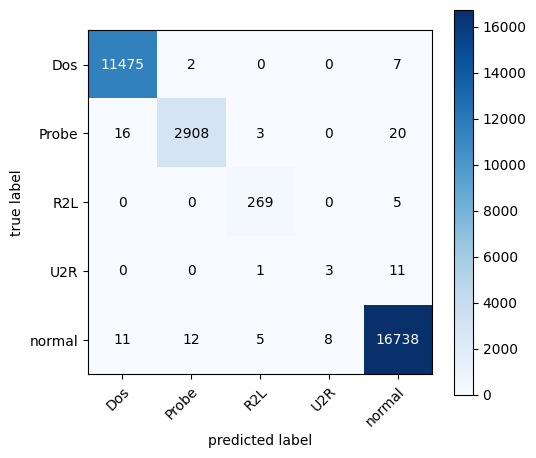

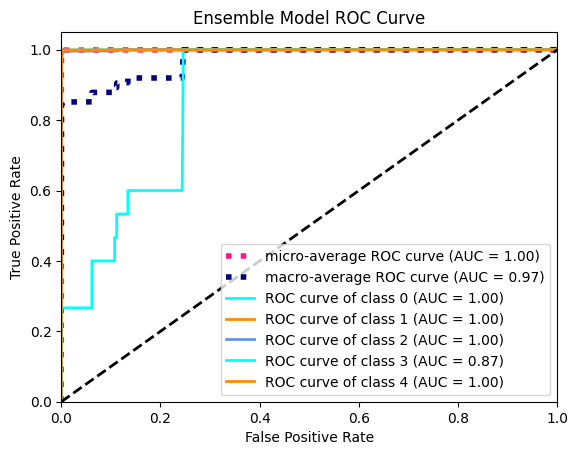

--------------------------------------------------

Ensemble Model Accuracy   = 99.68%

Ensemble Model Precision  = 99.68%

Ensemble Model Recall     = 99.68%

Ensemble Model F1 Score   = 99.68%

Cohen's Kappa             = 0.99

--------------------------------------------------



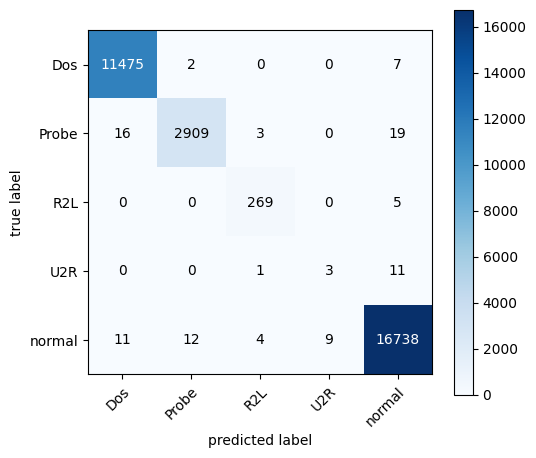

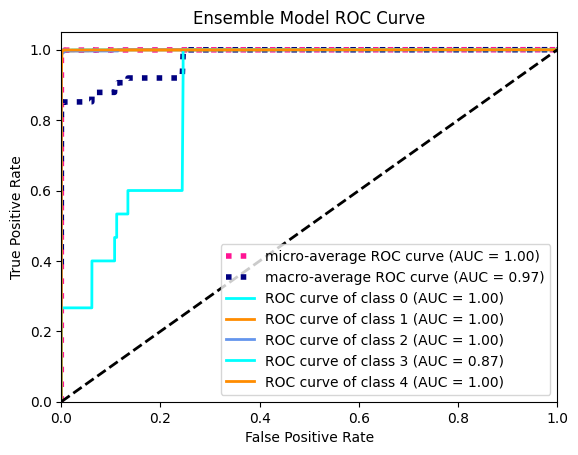

--------------------------------------------------

Ensemble Model Accuracy   = 99.68%

Ensemble Model Precision  = 99.68%

Ensemble Model Recall     = 99.68%

Ensemble Model F1 Score   = 99.68%

Cohen's Kappa             = 0.99

--------------------------------------------------



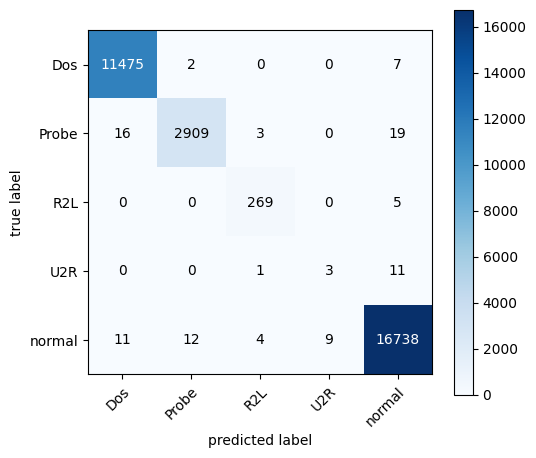

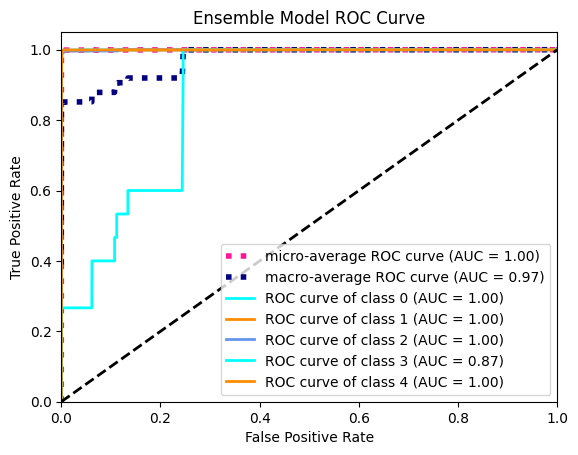

--------------------------------------------------

Ensemble Model Accuracy   = 99.82%

Ensemble Model Precision  = 99.82%

Ensemble Model Recall     = 99.82%

Ensemble Model F1 Score   = 99.81%

Cohen's Kappa             = 1.00

--------------------------------------------------



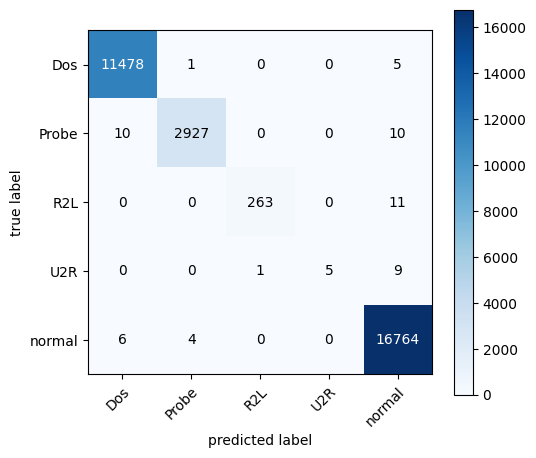

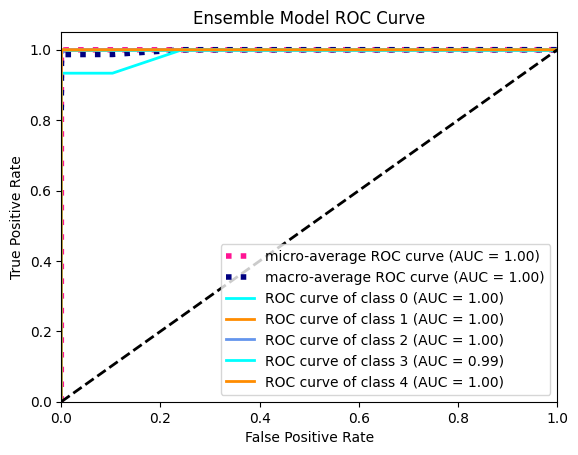

In [6]:
# Evaluate the ensemble model for each class
ensemble_and_evaluate(models_dos, X_test_train, Y_test_train)
ensemble_and_evaluate(models_r2l, X_test_train, Y_test_train)
ensemble_and_evaluate(models_probe, X_test_train, Y_test_train)
ensemble_and_evaluate(models_u2r, X_test_train, Y_test_train)